# Gradient Descent

We start by importing necessary libraries:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset, Dataset, random_split
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from collections import Counter
import math

In [2]:
# Set seed for model and default data type as specified
torch.set_default_dtype(torch.double)

def seeder(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seeder()

We now import the data and perform preprocessing. This is slightly tricky, as this includes computing mean and standard deviation of the training set, filtering out classes (we only want bird and plane), rebasing the remaining indices, and creating a separate validation set from the training set.

In [3]:
# Create a temporary set for getting mean and standard deviation of training set
transform_temp = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_temp)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_temp)

seeder()
loader_temp = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

for images, _ in loader_temp:
    mean = images.mean([0, 2, 3])
    std = images.std([0, 2, 3])
    print(f'Mean: {mean}')
    print(f'Std: {std}')

Files already downloaded and verified
Files already downloaded and verified
Mean: tensor([0.4914, 0.4822, 0.4465])
Std: tensor([0.2470, 0.2435, 0.2616])


In [4]:
# Function to filter out undesired labels
def filter_labels(data):
    
    # If data is a Subset instance
    if isinstance(data, Subset):
        parent_dataset = data.dataset
        original_indices = data.indices
        targets = [parent_dataset.targets[i] for i in original_indices]
        idx_map = {original_indices[i]: i for i in range(len(original_indices))}
    else:
        parent_dataset = data
        targets = parent_dataset.targets
        idx_map = None

    # Filtered indices
    idx = []
    for i in range(len(targets)):
        if targets[i] in [0, 2]:
            original_idx = original_indices[i] if idx_map else i
            idx.append(original_idx)

    # Return a new Subset based on the filtered indices
    return Subset(parent_dataset, idx)


In [5]:
# Wrapper class to rebase label indices
class RemapLabelsDataset(Dataset):
    def __init__(self, subset):
        self.subset = subset

    def __getitem__(self, index):
        # Retrieve the original item (image and label)
        x, y = self.subset[index]
        
        # Original label for bird
        if y == 2:  
            y = 1
        # Original label for plane remains the same
        elif y == 0:  
            pass
        else:
            raise ValueError("Found an unexpected label: {y}")
        
        return x, y

    def __len__(self):
        return len(self.subset)

We can now normalise the data with the mean and standard deviation of the training set:

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Splitting data
total_size = len(train_dataset)
val_size = int(total_size * 0.2)
train_size = total_size - val_size

seeder()
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

Before we filter the data, we can briefly analyse the whole CIFAR-10 training set:

In [8]:
# Class distribution

# Make temporary dataloader for the whole set of labels
train_loader_all = DataLoader(train_dataset, batch_size=64, shuffle=False)

def get_class_distribution(data_loader):
    class_counts = Counter()

    for _, labels in data_loader:
        class_counts.update(labels.tolist())

    return class_counts

class_distribution = get_class_distribution(train_loader_all)

for class_id, count in sorted(class_distribution.items()):
    print(f'Class {class_id}: {count} instances')

Class 0: 4027 instances
Class 1: 3990 instances
Class 2: 3994 instances
Class 3: 4033 instances
Class 4: 4037 instances
Class 5: 3976 instances
Class 6: 3975 instances
Class 7: 3965 instances
Class 8: 4002 instances
Class 9: 4001 instances


C:\Users\kavya\AppData\Local\Temp\ipykernel_16648\1502791909.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean).view(3, 1, 1)
C:\Users\kavya\AppData\Local\Temp\ipykernel_16648\1502791909.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std).view(3, 1, 1)


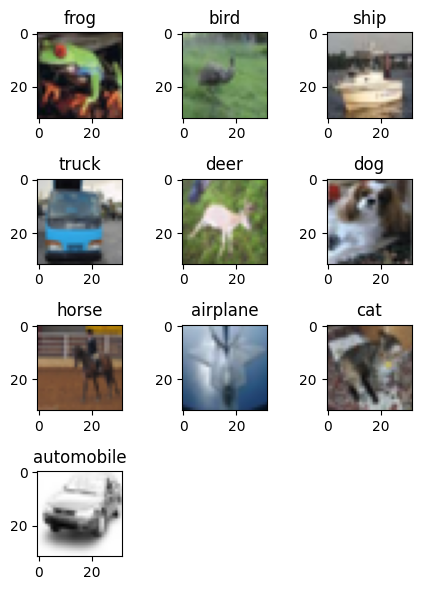

In [9]:
def display_classes(dataset, mean, std):
    # Get the names of the labels
    classes = dataset.dataset.classes
    num_classes = len(classes)
    
    # Determine size
    num_cols = int(math.sqrt(num_classes))
    num_rows = math.ceil(num_classes / num_cols)

    # Create a figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(1.5*num_cols, 1.5*num_rows))
    axes = axes.flatten()

    # Track the classes
    displayed_classes = set()

    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)

    for image, label in dataset:
        if label not in displayed_classes:
            # Denormalise
            img = image * std + mean
            npimg = img.numpy()
            npimg = np.clip(npimg, 0, 1)

            # Plot image
            ax = axes[len(displayed_classes)]
            ax.imshow(np.transpose(npimg, (1, 2, 0)))
            ax.set_title(classes[label])

            displayed_classes.add(label)

            # Break if all classes displayed
            if len(displayed_classes) == num_classes:
                break

    # Hide any remaining empty subplots
    for ax in axes[len(displayed_classes):]:
        ax.axis('off')

    # Adjust the layout
    plt.tight_layout()
    plt.show()

display_classes(train_dataset, mean, std)

In [10]:
# Filtering data
train_filt = filter_labels(train_dataset)
val_filt = filter_labels(val_dataset)
test_filt = filter_labels(test_dataset)

train_filt_remapped = RemapLabelsDataset(train_filt)
val_filt_remapped = RemapLabelsDataset(val_filt)
test_filt_remapped = RemapLabelsDataset(test_filt)

# Creating dataloaders
seeder()
train_loader = DataLoader(train_filt_remapped, batch_size=64, shuffle=False)
val_loader = DataLoader(val_filt_remapped, batch_size=64, shuffle=False)
test_loader = DataLoader(test_filt_remapped, batch_size=64, shuffle=False)

Some sanity checks to make sure that we have the correct classes with a reasonably balanced distribution:

C:\Users\kavya\AppData\Local\Temp\ipykernel_16648\1502791909.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean).view(3, 1, 1)
C:\Users\kavya\AppData\Local\Temp\ipykernel_16648\1502791909.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std).view(3, 1, 1)


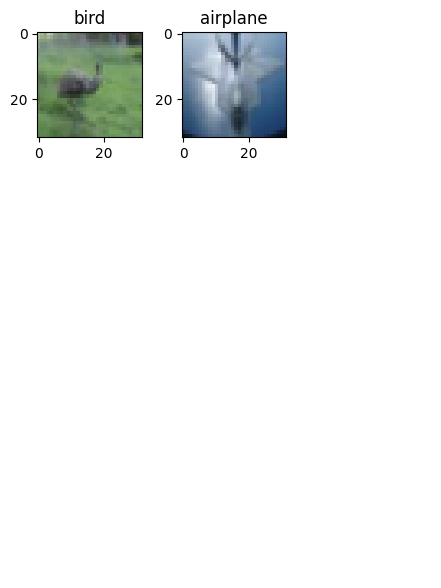

In [11]:
display_classes(train_filt, mean, std)

In [12]:
# Checking class distribution in all sets
class_distribution_training = get_class_distribution(train_loader)
class_distribution_val = get_class_distribution(val_loader)
class_distribution_test = get_class_distribution(test_loader)

print('Training:')
for class_id, count in sorted(class_distribution_training.items()):
    print(f'Class {class_id}: {count} instances')

print('Validation:')
for class_id, count in sorted(class_distribution_val.items()):
    print(f'Class {class_id}: {count} instances')

print('Test:')
for class_id, count in sorted(class_distribution_test.items()):
    print(f'Class {class_id}: {count} instances')


Training:
Class 0: 4027 instances
Class 1: 3994 instances
Validation:
Class 0: 973 instances
Class 1: 1006 instances
Test:
Class 0: 1000 instances
Class 1: 1000 instances


Now, we can design the actual model:

In [13]:
class MyMLP(nn.Module):
    def __init__(self):
        super(MyMLP, self).__init__()

        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 2)

    def forward(self, x):
        # Flatten for the fully-connected layers
        x = x.view(-1, 3072)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        return x

Now, we design the two training functions:

In [14]:
def train(n_epochs, optimizer, model, loss_fn, train_loader, get_loss=False):

    training_losses = []
    for epoch in range(n_epochs):
        total_loss = 0
        for i, (features, labels) in enumerate(train_loader):
            device = next(model.parameters()).device
            features, labels = features.to(device, dtype=torch.double), labels.to(device, dtype=torch.long)

            # Forward pass
            outputs = model(features)
            loss = loss_fn(outputs, labels)

            # Zero gradients
            optimizer.zero_grad()
            # Backward pass and gradient descent
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        training_losses.append(avg_loss)
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}')
    print('Training complete!')

    if get_loss:
        return training_losses

In [15]:
# Weight decay and momentum have default 0 if we wish to perform conventional GD
def train_manual_update(n_epochs, lr, model, loss_fn, train_loader, weight_decay=0, momentum=0, get_loss=False):
    training_losses = []

    if weight_decay < 0 or weight_decay > 1:
        raise ValueError("The weight decay has to be between 0 and 1")
    
    if momentum < 0 or momentum > 1:
        raise ValueError("The momentum has to be between 0 and 1")

    # Used for momentum
    velocity = {param: torch.zeros_like(param.data) for param in model.parameters() if param.requires_grad}

    for epoch in range(n_epochs):
        total_loss = 0
        for i, (features, labels) in enumerate(train_loader):
            device = next(model.parameters()).device
            features, labels = features.to(device, dtype=torch.double), labels.to(device, dtype=torch.long)

            outputs = model(features)
            loss = loss_fn(outputs, labels)

            for param in model.parameters():
                    if param.grad is not None:
                        param.grad.zero_()

            loss.backward()

            # Disable gradient computations for GD
            with torch.no_grad():
                for param in model.parameters():
                    if param.requires_grad:
                        grad_wd = param.grad + weight_decay * param
                        velocity[param] = momentum * velocity[param] + grad_wd
                        param -= lr * velocity[param]

            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        training_losses.append(avg_loss)
        print(f'Epoch {epoch+1}/{n_epochs}, Loss: {avg_loss:.4f}')
    print('Training complete!')

    if get_loss:
        return training_losses

Here (task 3.1.5) we make sure that we get the exact same values for both functions when we use the same parameters:

In [16]:
# Set seed to ensure same values
seeder()
model_standard = MyMLP()

seeder()
model_custom = MyMLP()

loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001
n_epochs = 10   

optimiser = SGD(model_standard.parameters(), lr=learning_rate)

train(n_epochs, optimiser, model_standard, loss_fn, train_loader)
print('\n')
train_manual_update(n_epochs, learning_rate, model_custom, loss_fn, train_loader)

Epoch 1/10, Loss: 0.6832
Epoch 2/10, Loss: 0.6645
Epoch 3/10, Loss: 0.6482
Epoch 4/10, Loss: 0.6340
Epoch 5/10, Loss: 0.6212
Epoch 6/10, Loss: 0.6093
Epoch 7/10, Loss: 0.5978
Epoch 8/10, Loss: 0.5867
Epoch 9/10, Loss: 0.5759
Epoch 10/10, Loss: 0.5656
Training complete!


Epoch 1/10, Loss: 0.6832
Epoch 2/10, Loss: 0.6645
Epoch 3/10, Loss: 0.6482
Epoch 4/10, Loss: 0.6340
Epoch 5/10, Loss: 0.6212
Epoch 6/10, Loss: 0.6093
Epoch 7/10, Loss: 0.5978
Epoch 8/10, Loss: 0.5867
Epoch 9/10, Loss: 0.5759
Epoch 10/10, Loss: 0.5656
Training complete!


Let's do this again, but including similar weight decay and momentum values:

In [17]:
seeder()
model_standard = MyMLP()

seeder()
model_custom = MyMLP()

loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001
n_epochs = 10   

optimiser = SGD(model_standard.parameters(), lr=learning_rate, weight_decay=0.01, momentum=0.5)

train(n_epochs, optimiser, model_standard, loss_fn, train_loader)
print('\n')
train_manual_update(n_epochs, learning_rate, model_custom, loss_fn, train_loader, weight_decay=0.01, momentum=0.5)

Epoch 1/10, Loss: 0.6746
Epoch 2/10, Loss: 0.6424
Epoch 3/10, Loss: 0.6172
Epoch 4/10, Loss: 0.5950
Epoch 5/10, Loss: 0.5742
Epoch 6/10, Loss: 0.5553
Epoch 7/10, Loss: 0.5388
Epoch 8/10, Loss: 0.5246
Epoch 9/10, Loss: 0.5124
Epoch 10/10, Loss: 0.5017
Training complete!


Epoch 1/10, Loss: 0.6746
Epoch 2/10, Loss: 0.6424
Epoch 3/10, Loss: 0.6172
Epoch 4/10, Loss: 0.5950
Epoch 5/10, Loss: 0.5742
Epoch 6/10, Loss: 0.5553
Epoch 7/10, Loss: 0.5388
Epoch 8/10, Loss: 0.5246
Epoch 9/10, Loss: 0.5124
Epoch 10/10, Loss: 0.5017
Training complete!


Now (task 3.1.8), we can train 4 different models with their own parameters:

In [18]:
# Different models
seeder()
model1 = MyMLP()
seeder()
model2 = MyMLP()
seeder()
model3 = MyMLP()
seeder()
model4 = MyMLP()
seeder()
model5 = MyMLP()

n_epochs = 20

# Different learning rates
lr1 = 0.01
lr2 = 0.05
lr3 = 0.005
lr4 = 0.1
lr5 = 0.1

# Different weight decay values
wd1 = 0.0005
wd2 = 0.0003
wd3 = 0.00007
wd4 = 0.0007
wd5 = 0.01

# Different momentum values
m1 = 0.5
m2 = 0.7
m3 = 0.3
m4 = 0.7
m5 = 0.6

tl1 = train_manual_update(n_epochs, lr1, model1, loss_fn, train_loader, wd1, m1, True)
print('\n')
tl2 = train_manual_update(n_epochs, lr2, model2, loss_fn, train_loader, wd2, m2, True)
print('\n')
tl3 = train_manual_update(n_epochs, lr3, model3, loss_fn, train_loader, wd3, m3, True)
print('\n')
tl4 = train_manual_update(n_epochs, lr4, model4, loss_fn, train_loader, wd4, m4, True)
print('\n')
tl5 = train_manual_update(n_epochs, lr5, model5, loss_fn, train_loader, wd5, m5, True)

Epoch 1/20, Loss: 0.5790
Epoch 2/20, Loss: 0.4716
Epoch 3/20, Loss: 0.4266
Epoch 4/20, Loss: 0.3929
Epoch 5/20, Loss: 0.3636
Epoch 6/20, Loss: 0.3363
Epoch 7/20, Loss: 0.3093
Epoch 8/20, Loss: 0.2832
Epoch 9/20, Loss: 0.2580
Epoch 10/20, Loss: 0.2358
Epoch 11/20, Loss: 0.2131
Epoch 12/20, Loss: 0.1913
Epoch 13/20, Loss: 0.1780
Epoch 14/20, Loss: 0.1524
Epoch 15/20, Loss: 0.1614
Epoch 16/20, Loss: 0.1375
Epoch 17/20, Loss: 0.1471
Epoch 18/20, Loss: 0.1239
Epoch 19/20, Loss: 0.1212
Epoch 20/20, Loss: 0.1047
Training complete!


Epoch 1/20, Loss: 0.4955
Epoch 2/20, Loss: 0.4145
Epoch 3/20, Loss: 0.3700
Epoch 4/20, Loss: 0.3327
Epoch 5/20, Loss: 0.2984
Epoch 6/20, Loss: 0.2626
Epoch 7/20, Loss: 0.2370
Epoch 8/20, Loss: 0.2197
Epoch 9/20, Loss: 0.2088
Epoch 10/20, Loss: 0.1887
Epoch 11/20, Loss: 0.1728
Epoch 12/20, Loss: 0.1663
Epoch 13/20, Loss: 0.1418
Epoch 14/20, Loss: 0.1428
Epoch 15/20, Loss: 0.1339
Epoch 16/20, Loss: 0.1129
Epoch 17/20, Loss: 0.1133
Epoch 18/20, Loss: 0.1242
Epoch 19/

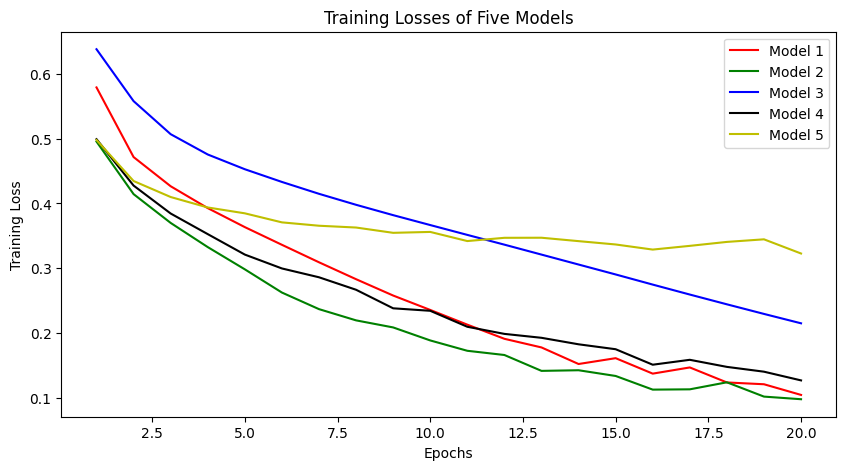

In [19]:
# Plot training losses
plt.figure(figsize=(10, 5))
epochs_list = list(range(1, 21))
plt.plot(epochs_list, tl1, label='Model 1', color='r')
plt.plot(epochs_list, tl2, label='Model 2', color='g')
plt.plot(epochs_list, tl3, label='Model 3', color='b')
plt.plot(epochs_list, tl4, label='Model 4', color='k')
plt.plot(epochs_list, tl5, label='Model 5', color='y')

plt.title('Training Losses of Five Models')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

Here, we can pick the best model with validation data:

In [20]:
# This function measures accuracy given a model and dataloader
def evaluate_model(model, data_loader):
    # Put model in evaluation mode
    model.eval() 
    correct = 0
    total = 0
    # Disable gradient computations
    with torch.no_grad():
        for i, (features, labels) in enumerate(data_loader):
            device = next(model.parameters()).device

            features, labels = features.to(device, dtype=torch.double), labels.to(device, dtype=torch.long)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

In [21]:
# Store models in dictionary
models_dict = {
    'Model 1': model1,
    'Model 2': model2,
    'Model 3': model3,
    'Model 4': model4,
    'Model 5': model5
}

# Storing validation accuracies
val_accs = {}

for name, model in models_dict.items():
    accuracy = evaluate_model(model, val_loader)
    val_accs[name] = accuracy
    print(f"{name} Validation Accuracy: {accuracy:.4f}")

Model 1 Validation Accuracy: 0.8550
Model 2 Validation Accuracy: 0.8388
Model 3 Validation Accuracy: 0.8545
Model 4 Validation Accuracy: 0.8186
Model 5 Validation Accuracy: 0.8186


Finally, we pick out the best performing model and test it on test data:

In [22]:
best_model_name = max(val_accs, key=val_accs.get)
best_model = models_dict[best_model_name]
print(f"Best Model: {best_model_name} with Validation Accuracy: {val_accs[best_model_name]:.4f}")

Best Model: Model 1 with Validation Accuracy: 0.8550


In [23]:
test_accuracy = evaluate_model(best_model, test_loader)
print(f"Test Accuracy of the best model ({best_model_name}): {test_accuracy:.4f}")

Test Accuracy of the best model (Model 1): 0.8560
